In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy
from numpy import zeros, asarray
from scipy.io import savemat
import pymadrigal
import datetime

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import mpld3

In [4]:
mpld3.enable_notebook()

In [5]:
filepath = '/home/breitsbw/data/isr/jro20020318_drifts.001'

In [6]:
column_names = pymadrigal.get_madrigal_column_names(filepath)
print(column_names)

['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'UT1_UNIX', 'UT2_UNIX', 'RECNO', 'RANGE', 'GDLATR', 'GDLONR', 'SPCST', 'PL', 'CBADN', 'INTTMS', 'AZDIR7', 'ELDIR7', 'AZDIR8', 'ELDIR8', 'GDALT', 'VIPN2', 'DVIPN2', 'VIPE1', 'DVIPE1', 'VI72', 'DVI72', 'VI82', 'DVI82', 'PAIWL', 'PACWL', 'PBIWL', 'PBCWL', 'PCIEL', 'PCCEL', 'PDIEL', 'PDCEL', '32000', '32001']


In [7]:
# parse data
data = pymadrigal.parse_madrigal_hdf5(filepath)

In [9]:
# process data into image
image = pymadrigal.create_2d_image(data)
print(image.shape)

(58, 8352)


In [10]:
# # create data matrix
# M = len(column_names)
# data_matrix = zeros((N, M))
# for i, column_name in enumerate(column_names):
#     data_matrix[:, i] = data[column_name]
# savemat('test.mat', {'DATA': data})

In [11]:
mpld3.disable_notebook()

In [12]:
# drift plot setup
extent = [numpy.min(data['RECNO']), numpy.max(data['RECNO']), numpy.min(data['GDALT']), numpy.max(data['GDALT'])]
xticks = [200, 4200, 8200]
xtick_labels = ['{hour:02}:{minute:02}'.format(hour=int(data['HOUR'][i]),
                                               minute=int(data['MIN'][i])) for i in xticks]
yticks = [15, 35, 55]
ytick_labels = ['{0}'.format(data['GDALT'][i]) for i in yticks]

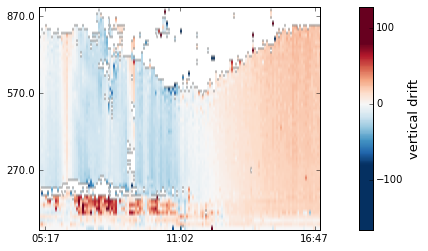

In [13]:
# drift plot
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
im = ax.imshow(image, aspect='auto', origin='lower', cmap=cm.RdBu_r)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
cax = divider.append_axes('right', size='5%', pad=0.55)
cb = plt.colorbar(im, orientation='vertical', cax=cax)
cb.set_label('vertical drift', fontsize=13)
cb.set_clim(-80, 80)
cb.set_ticks([-100, 0, 100])

### Average Drift Plot

In [5]:
filepath = '/home/breitsbw/data/isr/jro20020318_avg_drifts.001'

In [6]:
column_names = pymadrigal.get_madrigal_column_names(filepath)
print(column_names)

['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'UT1_UNIX', 'UT2_UNIX', 'RECNO', 'GDLATR', 'GDLONR', 'SPCST', 'PL', 'CBADN', 'INTTMS', 'RANGE', 'GDALT', 'ALTAV', 'VIPN2', 'DVIPN2', 'VIPE1', 'DVIPE1']


In [7]:
# parse data
data = pymadrigal.parse_madrigal_hdf5(filepath)

In [18]:
# get ave drift variables
image = pymadrigal.create_2d_image(data)
error = pymadrigal.create_2d_image(data, dtype='DVIPN2')
peru_timezone = datetime.timezone(datetime.timedelta(hours=5))
time = pymadrigal.get_record_datetimes(data, tzinfo=peru_timezone)
altitude = pymadrigal.get_record_altitudes(data, validate=False)

In [19]:
# fix times
unix_epoch = datetime.datetime(1970, 1, 1, tzinfo=datetime.timezone.utc)
unix_time = asarray([(t - unix_epoch).total_seconds() for t in time])

In [49]:
# set up ave drift plot
level = 0
peru_day_start = datetime.datetime(time[0].year, time[0].month, time[0].day, tzinfo=peru_timezone)
day_start_unix_offset = (peru_day_start - unix_epoch).total_seconds()
xticks = [5 * 3600, 11 * 3600, 17 * 3600, 23 * 3600, 29 * 3600]
xticks = [day_start_unix_offset + tick for tick in xticks]
xtick_datetimes = [unix_epoch + datetime.timedelta(seconds=tick) for tick in xticks]
xtick_datetimes = [dt.replace(tzinfo=peru_timezone) for dt in xtick_datetimes]
xtick_labels = ['{hour:02}:{minute:02}'.format(hour=dt.hour, minute=dt.minute) for dt in xtick_datetimes]
yticks = [-100, -50, 0, 50, 100]
ytick_labels = yticks
ylim = [-120, 120]

In [50]:
mpld3.disable_notebook()

(-120, 120)

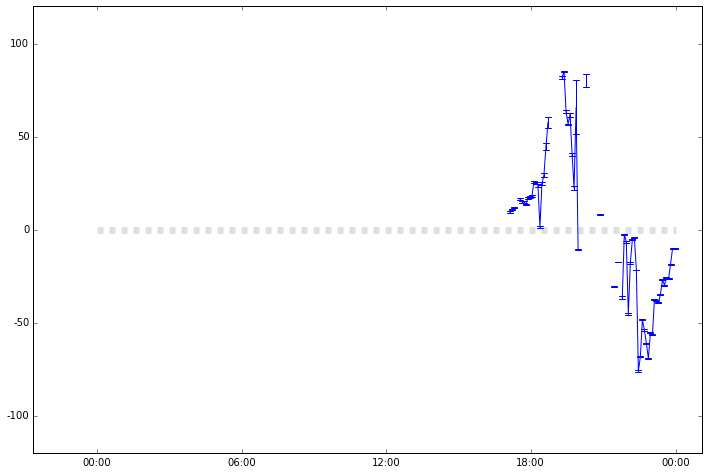

In [59]:
# ave drift plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.errorbar(unix_time, image[level, :], error[level, :])
ax.plot([xticks[0], xticks[-1]], [0, 0], '--', color=(.3, .4, .4, .2), linewidth=7)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_ylim(ylim)

.

.

.

.

In [ ]:
def get_record_altitudes(data, dtype='GDALT', validate=False):
    '''
    Creates y-axis altitude array from parsed Madrigal HDF5 data

    data -- the data parsed from `parse_madrigal_hdf5`
    dtype -- the data to use for the y axis
    validate -- whether or not to go through the data to check consistency across records
    '''
    altitudes = []
    recnos = data['RECNO']
    indices = recnos == recnos
    altitudes = data[dtype][indices]
    if validate:
        for recno in recnos[1:]:
            indices = recnos == recno
            assert(allzero(data[dtype][indices] - altitudes))
    return altitudes
def get_record_datetimes(data):
    '''
    Creates x-axis datetime list from parsed Madrigal HDF5 data

    data -- the data parsed from `parse_madrigal_hdf5`
    '''
    datetimes = []
    recnos = data['RECNO']
    for recno in recnos:
        i = where(recnos == recno)[0][0]
        year = data['YEAR'][i]
        month = data['MONTH'][i]
        day = data['DAY'][i]
        hour = data['HOUR'][i]
        minute = data['MIN'][i]
        second = data['SEC']
        datetimes.append(datetime.datetime(year, month, day, hour, minute, second))
    return datetimes

In [ ]:
class DriftPlot(object):
    '''
    A matplotlib style ion drift plot.
    '''
    xticks = [200, 4200, 8200]
    yticks = [15, 35, 55]

    def __init__(self, ax, data, **kwargs):
        '''
        ax -- the matplotlib axes on which to plot
        data -- the HDF5 data object
        '''
        # key word args
        for key, item in kwargs.iteritems():
            setattr(self, key, item)
        # drift plot setup
        extent = [numpy.min(data['RECNO']), numpy.max(data['RECNO']),
                  numpy.min(data['GDALT']), numpy.max(data['GDALT'])]
        xtick_labels = ['{hour:02}:{minute:02}'.format(hour=int(data['HOUR'][i]),
                                                       minute=int(data['MIN'][i])) for i in self.xticks]
        ytick_labels = ['{0}'.format(data['GDALT'][i]) for i in self.yticks]
        # drift plot
        divider = make_axes_locatable(ax)
        im = ax.imshow(image, aspect='auto', origin='lower', cmap=cm.RdBu)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        cax = divider.append_axes('right', size='5%', pad=0.55)
        cb = plt.colorbar(im, orientation='vertical', cax=cax)
        cb.set_label('vertical drift', fontsize=13)
        cb.set_clim(-80, 80)
        cb.set_ticks([-100, 0, 100])

In [15]:
# ave drift plot setup


In [8]:
mpld3.disable_notebook()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['UT1_UNIX'], data['RANGE'])

In [ ]:
from research.septentrio import Septentrio_FileManager, SBF_FileManager, SBF_Parser, SeptentrioDataset
from research.util import TimeWindow

In [35]:
file_manager = SBF_FileManager('/mnt/gluster/by-location/peru/gnsco/polarxs/')
parser = SBF_Parser('/home/breitsbw/data/septentrio_hdf5/config/gps_only.cfg',
                   '/home/breitsbw/projects/sbf-to-hdf5-converter/parse')

filepaths = file_manager.filepaths_during(TimeWindow.one_day_window(datetime.datetime(2013, 3, 12, tzinfo=datetime.timezone.utc)))
infilepath = next(filepaths)
outfilepath = '/home/breitsbw/data/septentrio_hdf5/peru/%s.h5' % basename(infilepath)
print(infilepath, outfilepath)
# parser.parse(infilepath, outfilepath)
dataset = SeptentrioDataset(outfilepath)
dataset.epoch

[(b'YEAR', b'Year (universal time)', 0, b'y', b'Time Related Parameter')
 (b'MONTH', b'Month (universal time)', 0, b'm', b'Time Related Parameter')
 (b'DAY', b'Day (universal time)', 0, b'd', b'Time Related Parameter')
 (b'HOUR', b'Hour (universal time)', 0, b'h', b'Time Related Parameter')
 (b'MIN', b'Minute (universal time)', 0, b'm', b'Time Related Parameter')
 (b'SEC', b'Second (universal time)', 0, b's', b'Time Related Parameter')
 (b'UT1_UNIX', b'Unix seconds (1/1/1970) at start', 0, b's', b'Time Related Parameter')
 (b'UT2_UNIX', b'Unix seconds (1/1/1970) at end', 0, b's', b'Time Related Parameter')
 (b'RECNO', b'Logical Record Number', 0, b'N/A', b'Time Related Parameter')
 (b'GDLATR', b'Reference geod latitude (N hemi=pos)', 0, b'deg', b'Geographic Coordinate')
 (b'GDLONR', b'Reference geodetic longitude', 0, b'deg', b'Geographic Coordinate')
 (b'SPCST', b'Spectral sampling time', 0, b'sec', b'Data Quality Parameter')
 (b'PL', b'Pulse length', 0, b'sec', b'Data Quality Paramet